In [23]:
from data.dataset import BreastCancerDataset
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

Load dataset

In [24]:
data_dir = Path("../data/")

num_bags = 1000
trainset = BreastCancerDataset(data_dir, mode="train", num_bags=num_bags)
testset = BreastCancerDataset(data_dir, mode="test", num_bags=num_bags)


In [25]:
# Sum all the 1000 features into one feature vector per sample 
data_train = np.array([trainset[i]["features"].sum(dim=0).numpy() for i in range(len(trainset))]).squeeze()
data_test = np.array([testset[i]["features"].sum(dim=0).numpy() for i in range(len(testset))]).squeeze()
data = np.concatenate((data_train, data_test), axis=0)


Use TSNE to visualise each sample in 2D 

In [26]:
tsne = TSNE(n_components=2)

embedding = tsne.fit_transform(data)

TSNE based on the labels and centers

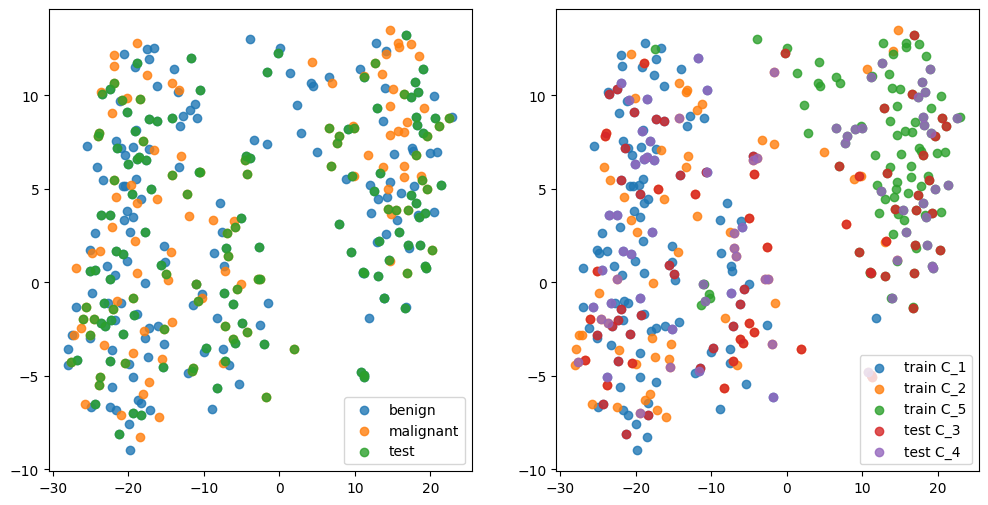

In [27]:
# TSNE based on the labels
idx_benign = np.where(trainset.labels == 0)[0]
idx_malignant = np.where(trainset.labels == 1)[0]
idx_test = np.where(testset.labels == -1)[0]

fig, ax = plt.subplots(1,2,figsize=(12, 6))

ax[0].scatter(embedding[idx_benign, 0], embedding[idx_benign, 1], label='benign', alpha=0.8)
ax[0].scatter(embedding[idx_malignant, 0], embedding[idx_malignant, 1], label='malignant', alpha=0.8)
ax[0].scatter(embedding[idx_test, 0], embedding[idx_test, 1], label='test', alpha=0.8)
ax[0].legend()

# TSNE based on the centers
idx_C1 = np.where(trainset.centers == 'C_1')[0]
idx_C2 = np.where(trainset.centers == 'C_2')[0]
idx_C5 = np.where(trainset.centers == 'C_5')[0]
idx_C3 = np.where(testset.centers == 'C_3')[0]
idx_C4 = np.where(testset.centers == 'C_4')[0]


ax[1].scatter(embedding[idx_C1, 0], embedding[idx_C1, 1], label='train C_1', alpha=0.8)
ax[1].scatter(embedding[idx_C2, 0], embedding[idx_C2, 1], label='train C_2', alpha=0.8)
ax[1].scatter(embedding[idx_C5, 0], embedding[idx_C5, 1], label='train C_5', alpha=0.8)
ax[1].scatter(embedding[idx_C3, 0], embedding[idx_C3, 1], label='test C_3', alpha=0.8)
ax[1].scatter(embedding[idx_C4, 0], embedding[idx_C4, 1], label='test C_4', alpha=0.8)
ax[1].legend()


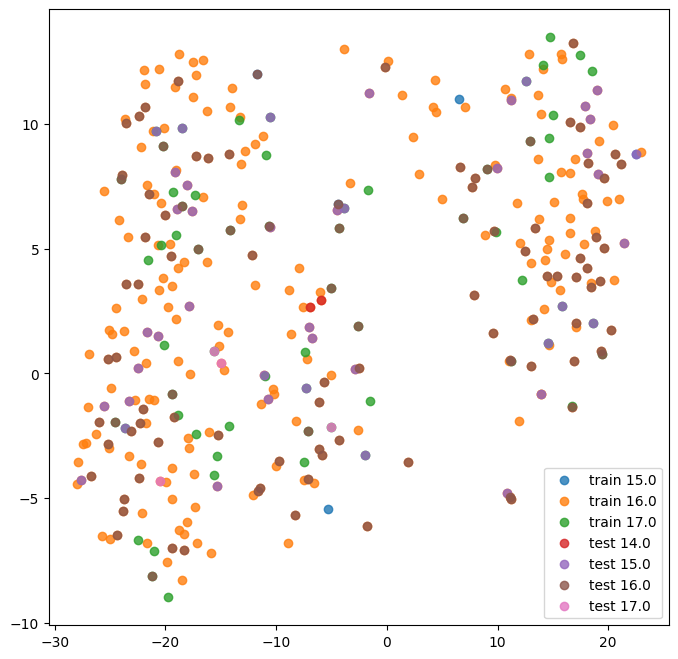

In [28]:
magnification_train = np.array([trainset[i]["coordinates"][:,0][0] for i in range(len(trainset))])
magnification_test = np.array([testset[i]["coordinates"][:,0][0] for i in range(len(testset))])

fig, ax = plt.subplots(figsize=(8, 8))
# TSNE based on the centers

for mag in np.unique(magnification_train):
    idx_mag = np.where(magnification_train == mag)[0]
    ax.scatter(embedding[idx_mag, 0], embedding[idx_mag, 1], label=f'train {mag}', alpha=0.8)
for mag in np.unique(magnification_test):
    idx_mag = np.where(magnification_test == mag)[0]
    ax.scatter(embedding[idx_mag, 0], embedding[idx_mag, 1], label=f'test {mag}', alpha=0.8)
ax.legend()

Look at the attention weights

In [6]:
from sklearn.model_selection import StratifiedKFold

# Get the validation data from the last split (the model was saved when training on this last fold)
dataset = BreastCancerDataset(data_dir, mode="train")

all_data = [dataset[i]["features"] for i in range(len(dataset))]
all_labels = [dataset[i]["label"] for i in range(len(dataset))]
all_samples = [dataset[i]["sample"] for i in range(len(dataset))]

# get the right validation index obtained with the saved model (last seed, last fold)
kfold = StratifiedKFold(5, shuffle=True, random_state=4) # the last seed 
split = kfold.split(all_data, all_labels, all_samples)
train_idx, val_idx = list(split)[-1]

# Get the validation data and the features
val_dataset = torch.utils.data.Subset(dataset, val_idx)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, num_workers=0) 
batch = next(iter(val_loader))
features = batch["features"]
print(features.shape)

torch.Size([68, 1000, 2048])


Load the attention model, and get the attention score of the validation data (unseen by the model)

In [7]:
from models.attention import AttentionMIL, AdditiveMIL
model_dir = Path("../results/additive/")

model = AdditiveMIL()
model.load_state_dict(torch.load(model_dir / 'model_weights.pth'))

model.eval()
with torch.no_grad():
    outputs = model(features)
    attention = model.attention(batch["features"]) # give an attention score for each tile 
print(attention.shape)

torch.Size([68, 1000, 1])


Distribution of the scores over the 1000 features (tiles) used

[]

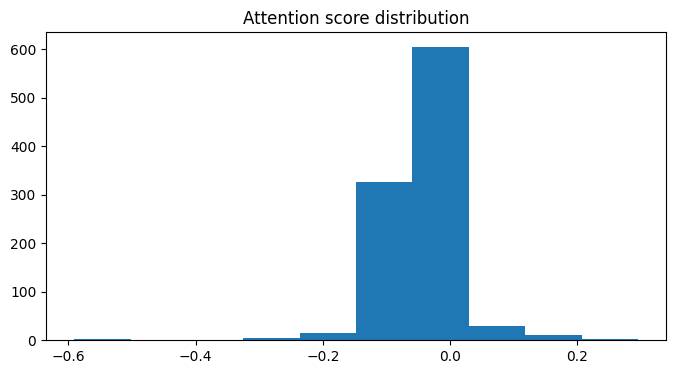

In [8]:
fig = plt.figure(figsize=(8, 4))
plt.hist(attention[0,:].numpy())
plt.title("Attention score distribution")
plt.plot()

Associate score with tile images

In [9]:
train_images_dir = data_dir / "train_input" / "images"
train_images_files = list(train_images_dir.rglob("*.jpg"))

In [10]:
ID_NUM = 1 # number to choose between 0 and len(val_idx)
SAMPLE_ID = trainset.samples[val_idx, 0][ID_NUM][:-4] 

print(f"{SAMPLE_ID} is part of the validation set ({len(val_idx)} samples)")

val_tiles = [p for p in train_images_files if SAMPLE_ID in p.name]
print(f"The sample {SAMPLE_ID} has {len(val_tiles)} tiles")
print(f"label {trainset.labels[val_idx][ID_NUM]}, prediction {outputs[ID_NUM].numpy():.2f}")

tiles_score = attention[ID_NUM, :].squeeze().numpy()
print(f"Each tile has a score from {np.min(tiles_score):.2f} to {np.max(tiles_score):.2f}")

ID_031 is part of the validation set (68 samples)
The sample ID_031 has 1000 tiles
label 1, prediction 1.00
Each tile has a score from -0.39 to 0.34


Get the tiles with the highest score

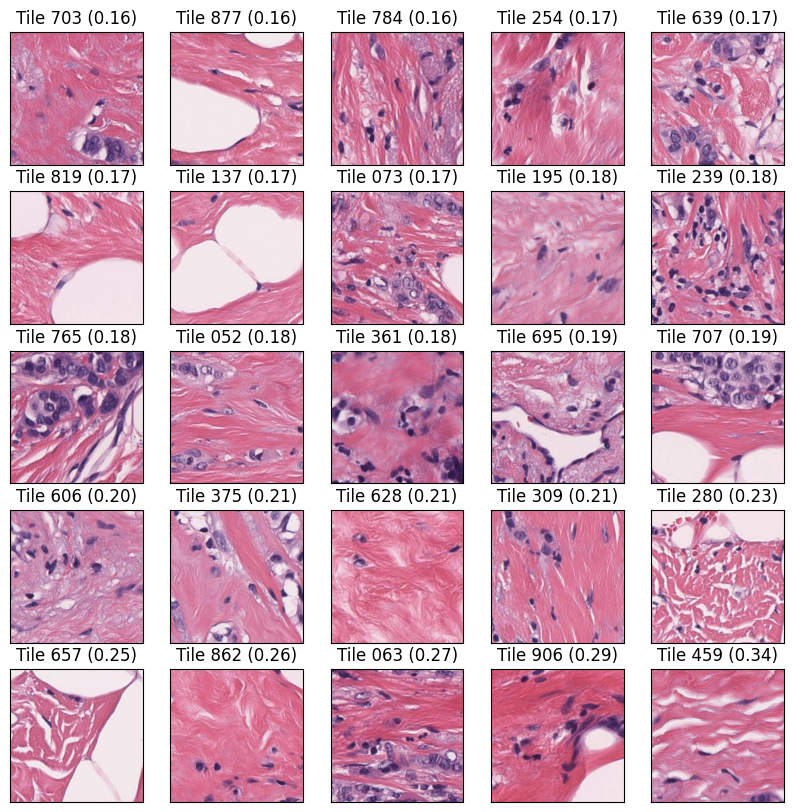

Sample ID_031 -- label: 1, prediction: 1.00


In [11]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(10, 10)

idx_max_score = np.argsort(tiles_score)[-25:] # highest attention score

for i, idx in enumerate(idx_max_score):
    img_file = val_tiles[idx]
    # get the metadata from the file path
    _, metadata = str(img_file).split("tile_")
    id_tile, level, x, y = metadata[:-4].split("_")
    img = plt.imread(img_file)
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Tile {id_tile} ({tiles_score[idx]:.2f})")
plt.show()
print(f"Sample {SAMPLE_ID} -- label: {trainset.labels[val_idx[ID_NUM]]}, prediction: {outputs[ID_NUM].numpy():.2f}")

Lowest attention score

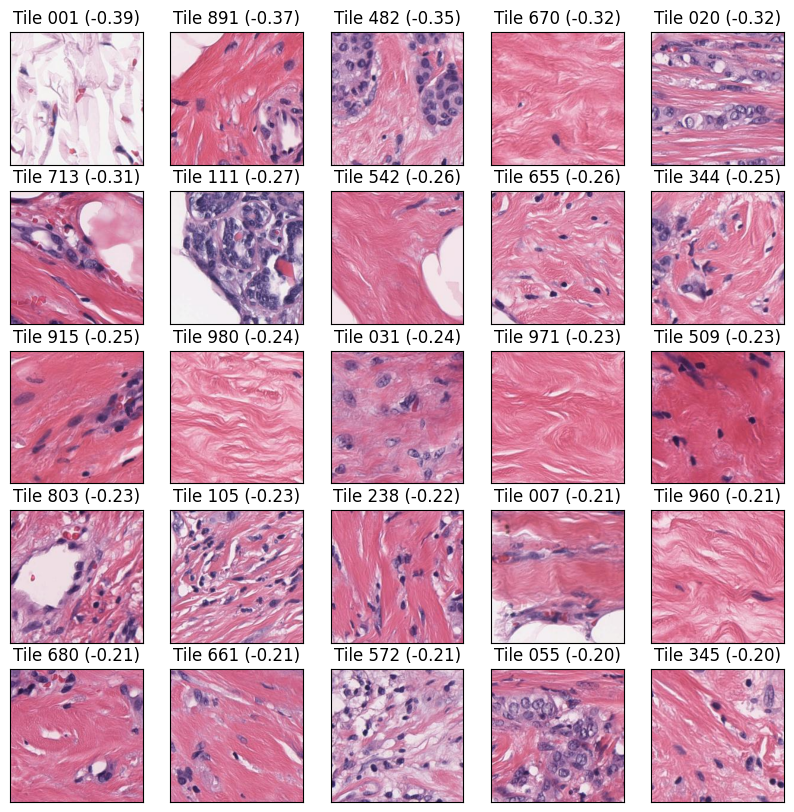

Sample ID_031 -- label: 1, prediction: 1.00


In [12]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(10, 10)

idx_min_score = np.argsort(tiles_score)[:25] # highest attention score

for i, idx in enumerate(idx_min_score):
    img_file = val_tiles[idx]
    # get the metadata from the file path
    _, metadata = str(img_file).split("tile_")
    id_tile, level, x, y = metadata[:-4].split("_")
    img = plt.imread(img_file)
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Tile {id_tile} ({tiles_score[idx]:.2f})")
plt.show()
print(f"Sample {SAMPLE_ID} -- label: {trainset.labels[val_idx[ID_NUM]]}, prediction: {outputs[ID_NUM].numpy():.2f}")

Plot the score relative to the image position

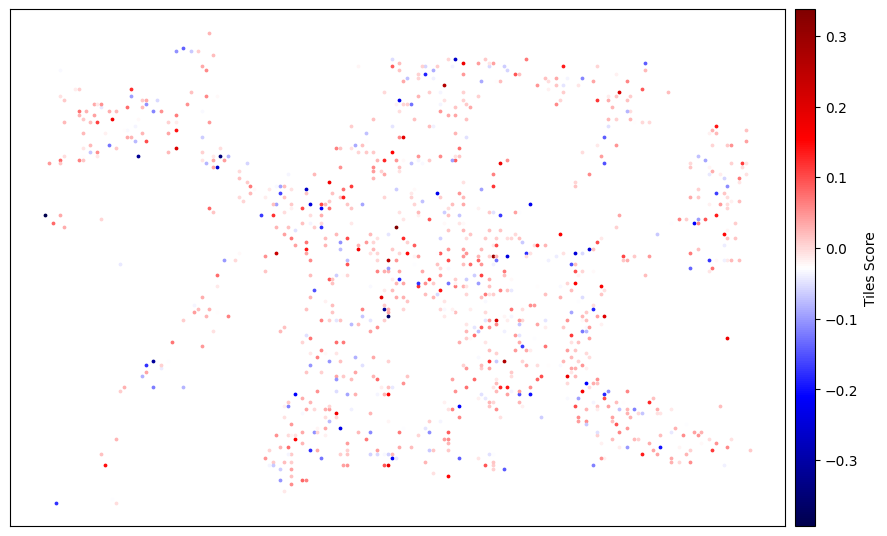

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))

cmap = plt.get_cmap('seismic')
norm = plt.Normalize(min(tiles_score), max(tiles_score))

for idx, img_file in enumerate(val_tiles):
    # get the metadata from the file path
    _, metadata = str(img_file).split("tile_")
    id_tile, level, x, y = metadata[:-4].split("_")
    color = cmap(norm(tiles_score[idx]))
    ax.scatter(int(x), int(y), color=color, s=3)
ax.set_xticks([])
ax.set_yticks([])

ax.set_aspect('equal')
cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cbar.set_label('Tiles Score')

plt.show()
